In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('desafio_indicium_imdb.csv', index_col=0)

In [3]:
# Visão geral de informações relevantes
data_overview = pd.DataFrame({
    "Tipo": df.dtypes,
    "Nulos": df.isnull().sum(),
    "% Nulos": df.isnull().mean()*100,
    "Valores Únicos": df.nunique(),
    "Exemplo de Valores": df.apply(lambda x: ", ".join([str(v) for v in x.dropna().unique()[:3]])),
})
data_overview

,Tipo,Nulos,% Nulos,Valores Únicos,Exemplo de Valores
Series_Title,object,0,0.000000,998,"The Godfather, The Dark Knight, The Godfather:..."
Released_Year,object,0,0.000000,100,"1972, 2008, 1974"
Certificate,object,101,10.110110,16,"A, UA, U"
Runtime,object,0,0.000000,140,"175 min, 152 min, 202 min"
Genre,object,0,0.000000,202,"Crime, Drama, Action, Crime, Drama, Action, Ad..."
IMDB_Rating,float64,0,0.000000,16,"9.2, 9.0, 8.9"
Overview,object,0,0.000000,999,An organized crime dynasty's aging patriarch t...
Meta_score,float64,157,15.715716,63,"100.0, 84.0, 90.0"
Director,object,0,0.000000,548,"Francis Ford Coppola, Christopher Nolan, Sidne..."
Star1,object,0,0.000000,659,"Marlon Brando, Christian Bale, Al Pacino"


In [4]:
# Limpando potenciais espaços desnecessários nos nomes das colunas, caso existam
df.columns = df.columns.str.strip()
# Linhas e Colunas
print(f"{df.shape[0]} linhas & {df.shape[1]} colunas")
# Verificando duplicadas
print("Duplicadas:", df.duplicated().sum())

999 linhas & 15 colunas
Duplicadas: 0


In [5]:
# Transformando variáveis para numéricas e fazendo as limpezas necessárias
df["Gross"] = pd.to_numeric(df["Gross"].str.replace(",", ""), errors="coerce")
df["Runtime"] = pd.to_numeric(df["Runtime"].str.replace(" min", ""), errors="coerce")
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce").astype("Int64")

In [6]:
df.head(5)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
5,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


In [7]:
df[df["Series_Title"] == "Drishyam"]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
87,Drishyam,2013,U,160,"Crime, Drama, Thriller",8.3,A man goes to extreme lengths to save his fami...,NaN,Jeethu Joseph,Mohanlal,Meena,Asha Sharath,Ansiba,30722,NaN
136,Drishyam,2015,UA,163,"Crime, Drama, Mystery",8.2,Desperate measures are taken by a man who trie...,NaN,Nishikant Kamat,Ajay Devgn,Shriya Saran,Tabu,Rajat Kapoor,70367,739478.0


### Released Year

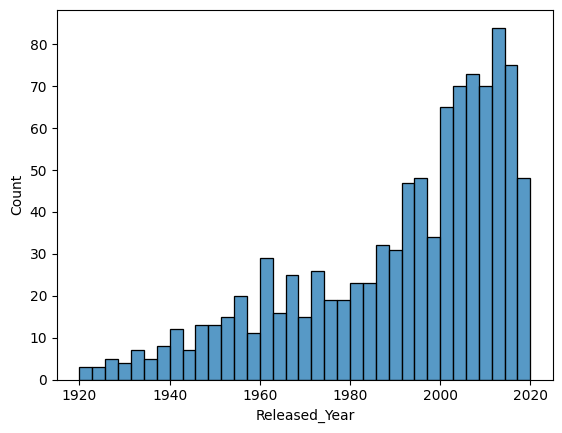

count          998.0
mean     1991.214429
std        23.308539
min           1920.0
25%           1976.0
50%           1999.0
75%           2009.0
max           2020.0
Name: Released_Year, dtype: Float64

In [ ]:
anos = df["Released_Year"]

sns.histplot(anos.dropna(), bins=35)
plt.show()

anos.describe()

### Genre

In [26]:
df["Genre_list"] = df["Genre"].str.split(", ")
df_xgenre = df.explode("Genre_list")

genre = df_xgenre["Genre_list"]

absolute_values = genre.value_counts()
relative_values = (absolute_values/len(df))*100

absolute_values, relative_values


(Genre_list
 Drama        723
 Comedy       233
 Crime        209
 Adventure    196
 Action       189
 Thriller     137
 Romance      125
 Biography    109
 Mystery       99
 Animation     82
 Sci-Fi        67
 Fantasy       66
 History       56
 Family        56
 War           51
 Music         35
 Horror        32
 Western       20
 Film-Noir     19
 Sport         19
 Musical       17
 Name: count, dtype: int64,
 Genre_list
 Drama        72.372372
 Comedy       23.323323
 Crime        20.920921
 Adventure    19.619620
 Action       18.918919
 Thriller     13.713714
 Romance      12.512513
 Biography    10.910911
 Mystery       9.909910
 Animation     8.208208
 Sci-Fi        6.706707
 Fantasy       6.606607
 History       5.605606
 Family        5.605606
 War           5.105105
 Music         3.503504
 Horror        3.203203
 Western       2.002002
 Film-Noir     1.901902
 Sport         1.901902
 Musical       1.701702
 Name: count, dtype: float64)

### Certificate

In [12]:
df["Certificate"].value_counts()

Certificate
U           234
A           196
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
Unrated       1
TV-MA         1
16            1
U/A           1
Name: count, dtype: int64

### IMDB_Rating